<a href="https://colab.research.google.com/github/Abbta/Kandarbete-LyapunovRNN/blob/main/Final_LE_calc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

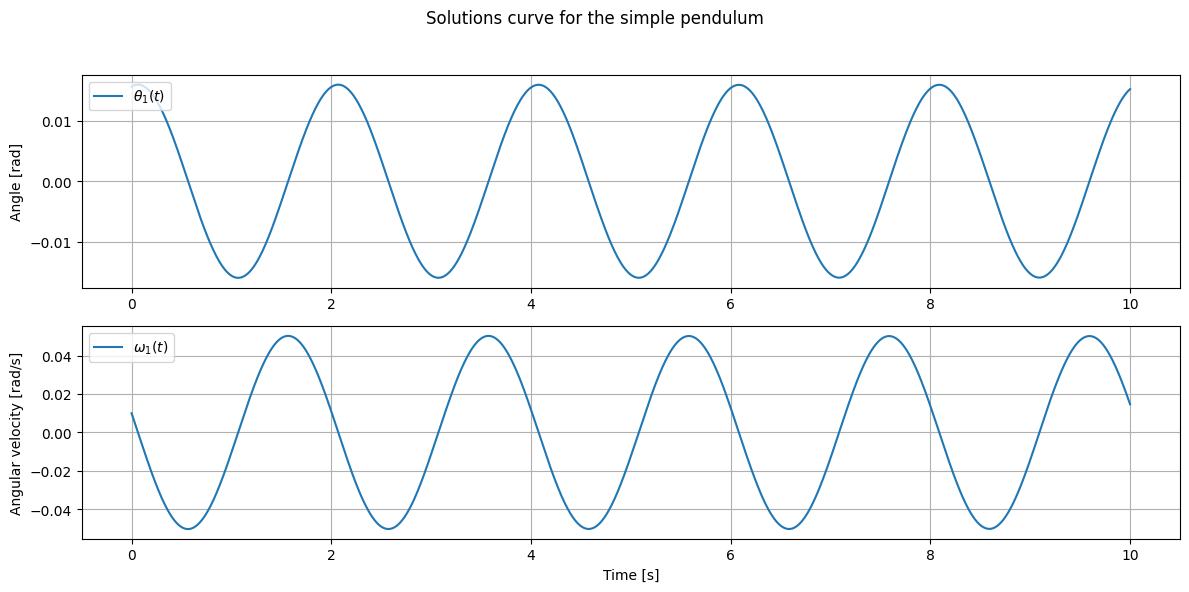

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.4234 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011 - val_loss: 2.8540e-04 - learning_rate: 0.0010
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0569e-04 - val_loss: 1.6321e-04 - learning_rate: 0.0010
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1716e-04 - val_loss: 1.3403e-04 - learning_rate: 0.0010
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.2986e-05 - val_loss: 1.1863e-04 - learning_rate: 0.0010
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.0555e-05 - val_loss: 1.0756e-04 - learning_rate: 0.0010
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.1570e-05 - val_loss: 9.9762e-05 - learning_rate: 0.0010
Epoch 8/20
65/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.4501e-05
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.4660e

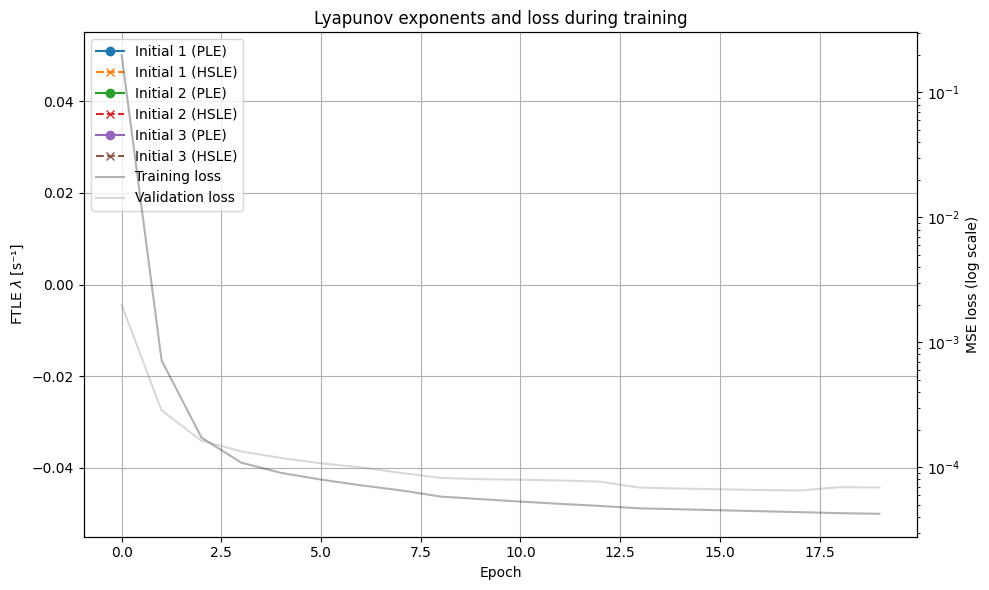

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


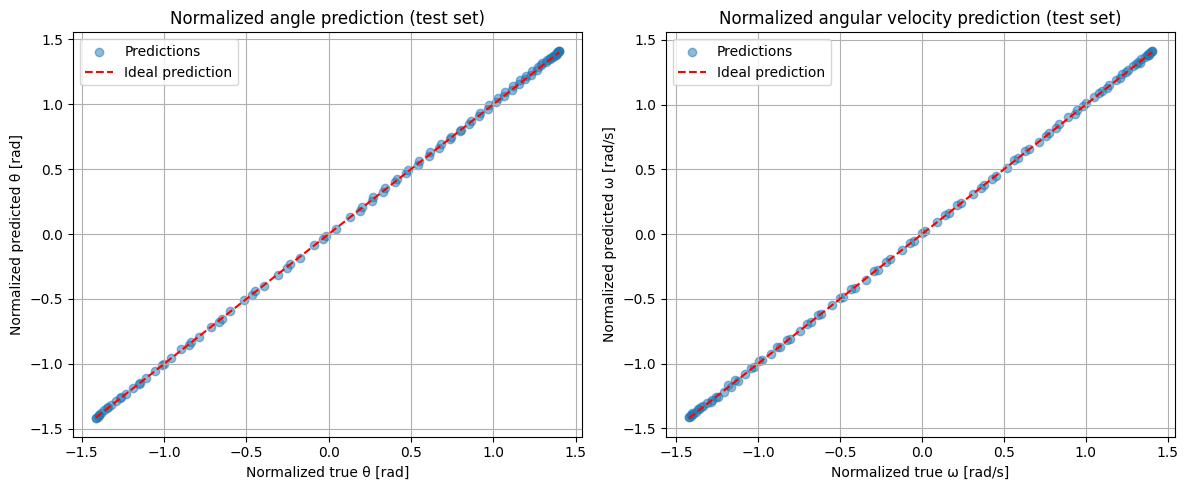

IndexError: list index out of range

In [ ]:




import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import random
from scipy.integrate import solve_ivp
import numpy as np
from sklearn.preprocessing import StandardScaler

layers = keras.layers


# Configurations for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


# Constants
g = 9.81
L1 = 1.0
L2 = 1.0
m1 = 1.0
m2 = 1.0

# initial states for plot
y0 = [np.pi/2, 1, np.pi/2, 1]

initials = [[np.pi/2, 1, np.pi/2, 1], [np.pi/4, -1, np.pi/4, -1], [-np.pi/2, 0, np.pi/2, 0], [0.1, 2.0, 3*np.pi/4, -1.5], [np.pi, 0.5, -np.pi/2, -0.5], [-np.pi, -2.0, np.pi/3, 1.0]]
initials_lyaps = [1.40176, 1.59057, 2.28863, 2.7653, 2.8809, 2.94079]

# ---------------------- Signal Definitions ---------------------- #
def f_sin(t, mean, sigma):
    """Sinusoidal signal with Gaussian noise."""
    input_noise = np.random.normal(loc=mean, scale=sigma, size=len(t))
    return np.sin(2 * np.pi * t), input_noise


def f_pendulum(t, mean, sigma, init):

    """Pendulum signal with Gaussian noise."""

    θ1, θ2 = solve_pendulum(t, init)
    input_noise = np.random.normal(mean, sigma, size=len(t))
    if angle_choice == 1:
        return θ1, input_noise
    else:
        return θ2, input_noise

# ---------------------- Solve Double Pendulum ---------------------- #

def double_pendulum_derivs(t, y):
    """
    EOM of the double pendulum.
    """
    θ1, ω1, θ2, ω2 = y
    Δ = θ2 - θ1

    # denominators
    D1 = (m1 + m2) * L1 - m2 * L1 * np.cos(Δ)**2
    D2 = (m1 + m2) * L2 - m2 * L2 * np.cos(Δ)**2

    # first‐order angles
    dθ1 = ω1
    dθ2 = ω2

    # ω1 numerator
    num1 = (
        m2 * L1 * ω1**2 * np.sin(Δ) * np.cos(Δ)
        + m2 * g * np.sin(θ2) * np.cos(Δ)
        + m2 * L2 * ω2**2 * np.sin(Δ)
        - (m1 + m2) * g * np.sin(θ1)
    )
    dω1 = num1 / D1

    # ω2 numerator
    num2 = (
        -m2 * L2 * ω2**2 * np.sin(Δ) * np.cos(Δ)
        + (m1 + m2) * (
            g * np.sin(θ1) * np.cos(Δ)
            - L1 * ω1**2 * np.sin(Δ)
            - g * np.sin(θ2)
        )
    )
    dω2 = num2 / D2

    return [dθ1, dω1, dθ2, dω2]


def solve_pendulum(t, init):
    """
    Solve the simple and double pendulum equations of motion using solve_ivp.
    """
    if system_type == 'simple' and angle_choice == 2:
        raise ValueError("Simple pendulum has only one angle. Set angle_choice = 1.")

    elif system_type == 'double':
        sol = solve_ivp(double_pendulum_derivs, (t[0], t[-1]), init, t_eval=t, method='DOP853')
        θ1, ω1, θ2, ω2 = sol.y[0], sol.y[1], sol.y[2], sol.y[3]

    elif 'simple' in system_type:

        def simple_pendulum(t, y):
            θ, ω = y
            return [ω, -g / L1 * np.sin(θ)]

        if 'chaotic' in system_type:
            sol = solve_ivp(simple_pendulum, (t[0], t[-1]), init[:2], t_eval=t, method='DOP853')
        else:
            sol = solve_ivp(simple_pendulum, (t[0], t[-1]), [i/10 for i in init[:2]], t_eval=t, method='DOP853') # non chaotic initial condition (first two initals)

        θ1, ω1 = sol.y[0], sol.y[1]
        θ2 = np.zeros_like(θ1)  # dummy since there is only one angle
        ω2 = np.zeros_like(ω1)  # dummy

    else:
        raise ValueError("Invalid system type")

    return θ1, ω1, θ2, ω2


# ---------------------- Lyapunov Calculator ---------------------- #
def lp_numeric(k, input_noise_norm, output_noise_norm):
    """Estimate Lyapunov exponent for the network predictions from input/output noise norms. l here is the network layer index."""
    return np.log(output_noise_norm / input_noise_norm) / k


def lp_analytical(initial, t, end):
    """
    Estimate the largest Lyapunov exponent from two nearby initial conditions for the "exact" solution.
    """

    pert = np.random.normal(0, 0.01, size=4) # perturbed initial parameters

    # Integrate both trajectories
    sol1 = solve_ivp(double_pendulum_derivs, (0, end), initial, t_eval=t, method='DOP853')
    sol2 = solve_ivp(double_pendulum_derivs, (0, end), initial + pert, t_eval=t, method='DOP853')

    delta = np.linalg.norm(sol2.y - sol1.y, axis=0) # Compute the distance between the two trajectories at each time step
    delta_initial = np.linalg.norm(pert) # Initial perturbation magnitude
    lyap = np.log(delta / delta_initial) # Lyapunov exponent estimate as a function of time

    return lyap / t # return computed lyapunov per time step


def rnn_jac(Wxh, Whh, ht, xt, phiprime):
    """
    Compute the Jacobian of the RNN with respect to the hidden state ht
    :param Wxh: input-to-hidden weight matrix (U)
    :param Whh: hidden-to-hidden weight matrix (V)
    :param ht: current hidden state
    :param xt: current input
    :param phiprime: function handle for the derivative of the activation function
    :return: Jacobian matrix
    """
    ht = np.reshape(ht, [-1, 1])  # shape: (32, 1)
    xt = np.reshape(xt, [-1, 1])  # shape: (32, 1)
    # Compute the Jacobian of the RNN with respect to ht


    alpha=Wxh@xt + Whh@ht
    J=np.diag(phiprime(alpha).flatten())@Whh
    return J

def calc_LEs(x_batches, h0, RNNlayer, activation_function_prim=lambda x:np.heaviside(x,1), k_LE=1000):
    """
    Calculate the Lyapunov exponents of a batch of sequences using the QR method.
    :param x_batches: input sequences (batch_size, T, input_size)
    :param h0: initial hidden state (batch_size, hidden_size)
    :param RNNlayer: RNN layer object (e.g., tf.keras.layers.SimpleRNN)
    :param activation_function_prim: function handle to derivative of activation function used in the RNN layer
    :param k_LE: number of Lyapunov exponents to compute
    :return: Lyapunov exponents for each batch (batch_size, k_LE)
    """
    #get dimensions
    batch_size, hidden_size = h0.shape
    batch_sizeX, T, input_size = x_batches.shape
    if batch_size != batch_sizeX:
        raise ValueError("batch size of h and X not compatible")
    L = hidden_size

    #get recurrent cell
    RNNcell=RNNlayer.cell

    # Choose how many exponents to track
    k_LE = max(min(L, k_LE), 1)

    #save average Lyapunov exponent over the sequence for each batch
    lyaps_batches = np.zeros((batch_size, k_LE))
    #Loop over input sequence
    for batch in range(batch_size):
        x=x_batches[batch]
        ht=h0[batch]
        #Initialize Q
        Q = tf.eye(L)
        #keep track of average lyapunov exponents
        cum_lyaps = tf.zeros((k_LE,))

        for t in range(T):
            #Get next state ht+1 by taking a reccurent step
            xt=x[t]
            _, ht = RNNcell(xt, ht)

            #Get jacobian J
            Wxh, Whh, b = rnn_layer.get_weights()
            # Transpose to match math-style dimensions
            Wxh = Wxh.T  # Now shape (units, input_dim)
            Whh = Whh.T  # Now shape (units, units)
            J = rnn_jac(Wxh, Whh, ht, xt, activation_function_prim)
            #Get the Lyapunov exponents from qr decomposition
            Q=Q@J
            Q,R=tf.linalg.qr(Q, full_matrices=False)
            cum_lyaps += tf.math.log(tf.math.abs(tf.linalg.diag_part(R[0:k_LE, 0:k_LE])))
        lyaps_batches[batch] = cum_lyaps / T
    return lyaps_batches


# ---------------------- Data Generation ---------------------- #

def get_data_full_state(initial):
    """
    Generate training data using unperturbed dynamics, and return a unperturbed and a perturbed input version.
    Also returns the total noise vector as one array on the form [N, 2].
    """

    n = N - window_size - 1
    t = np.linspace(0, end, N)

    θ1, ω1, θ2, ω2 = solve_pendulum(t, initial)
    θ = θ1 if angle_choice == 1 else θ2
    ω = ω1 if angle_choice == 1 else ω2

    # Generate Gaussian noise for angle and angular velocity
    noise = np.random.normal(mean, sigma, size=len(t))

     # Perturbed versions
    θ_pert = θ + noise
    ω_pert = ω + noise

    # Normalize θ and ω separately using StandardScaler
    scaler_theta = StandardScaler()
    scaler_omega = StandardScaler()

    θ_scaled = scaler_theta.fit_transform(θ.reshape(-1, 1)).flatten()
    ω_scaled = scaler_omega.fit_transform(ω.reshape(-1, 1)).flatten()
    θ_pert_scaled = scaler_theta.transform(θ_pert.reshape(-1, 1)).flatten()
    ω_pert_scaled = scaler_omega.transform(ω_pert.reshape(-1, 1)).flatten()

    # Stack noise vectors for full input noise (shape: [N, 2])
    input_noise = np.stack([noise, noise], axis=1)

    # Construct training sequences
    X = np.stack([np.stack([θ_scaled[i: i + window_size], ω_scaled[i: i + window_size]], axis=1) for i in range(n)])
    X_pert = np.stack([np.stack([θ_pert_scaled[i: i + window_size], ω_pert_scaled[i: i + window_size]], axis=1) for i in range(n)])

    # labels [θ, ω]
    y = np.stack([np.array([θ_scaled[i + window_size], ω_scaled[i + window_size]]) for i in range(n)])

    # Train/test split
    split_idx = int(0.90 * n) # 90% for training, 10% for testing for computational efficiency
    return X[:split_idx], y[:split_idx], X_pert[:split_idx], X[split_idx:], y[split_idx:], X_pert[split_idx:], θ, ω, θ_pert, ω_pert, input_noise, t


def get_test_sets(initials):
    """
    Generate test sets for different initial conditions.
    """

    test_sets = []
    for initial in initials:
        _, _, _, X_test, y_test, X_pert_test, *_ = get_data_full_state(initial)
        test_sets.append((X_test, y_test, X_pert_test))

    return test_sets, X_test, y_test, X_pert_test


# ---------------------- Model ---------------------- #
class LyapunovCallback(keras.callbacks.Callback):
    """
    Custom callback to compute Lyapunov exponents after each epoch.
    """

    def __init__(self, test_sets, k, number_exponents):
        self.test_sets = test_sets  # list of (X_clean, y, X_pert)
        self.k = k
        self.number_exponents = number_exponents
        self.lyap_list_all = [[] for _ in test_sets]
        self.lyap_list_jac_all = [[] for _ in test_sets]
        self.lyap_list_jac_noise_all = [[] for _ in test_sets]

    def on_epoch_end(self, epoch, logs=None):
        for set_idx, (X_clean_seq, _, X_pert_seq) in enumerate(self.test_sets): # loop over test sets
            lyaps = []
            lyaps_jac = []

            for i in range(len(X_clean_seq)):
                x_clean = X_clean_seq[i]
                x_pert = X_pert_seq[i]

                x_noise = x_pert - x_clean # noise in phase space
                input_noise_norm = np.linalg.norm(x_noise) / x_clean.shape[0]

                θ_clean_pred, ω_clean_pred = predict_k_steps(self.model, x_clean, self.k)
                θ_pert_pred, ω_pert_pred = predict_k_steps(self.model, x_pert, self.k)

                output_noise = np.stack([θ_pert_pred - θ_clean_pred, ω_pert_pred - ω_clean_pred], axis=1)
                output_noise_norm = np.linalg.norm(output_noise) / len(output_noise)

                lyap = lp_numeric(self.k, input_noise_norm, output_noise_norm)
                lyaps.append(lyap)


                # Jacobian method on a few
                H0 = np.random.rand(1, hidden_dim)

                x_clean_batch = x_clean[np.newaxis, :, :] # add axis
                x_clean_batch_noise = x_noise[np.newaxis, :, :]


                lyap_jac = max(calc_LEs(x_clean_batch, H0, rnn_layer, tanh_prim, self.number_exponents)[0])
                # lyap_jac_noise = max(calc_LEs(x_clean_batch_noise, H0, rnn_layer, tanh_prim, self.number_exponents)[0])

                lyaps_jac.append(lyap_jac)

            # Store means for this test set
            self.lyap_list_all[set_idx].append(np.mean(lyaps))
            self.lyap_list_jac_all[set_idx].append(np.mean(lyaps_jac))
            # self.lyap_list_jac_noise_all[set_idx].append(np.mean(lyap_jac_noise))

            print(f" | Epoch {epoch+1} | Initial {set_idx+1}: <PLE λ> = {round(np.mean(lyaps), 4)} s⁻¹, <HSLE λ> = {round(np.mean(lyaps_jac), 4)} s⁻¹")


# ---------------------- Model ---------------------- #

def define_model():
    """Model that takes [θ, ω] sequences and predicts next [θ, ω]."""

    z0 = layers.Input(shape=[None, 2])  # time steps unspecified, 2 features
    z = layers.SimpleRNN(32, activation="tanh")(z0)
    z = layers.Dense(32, activation='relu')(z)
    z = layers.Dense(16, activation='relu')(z)
    z = layers.Dense(2)(z)

    model = keras.models.Model(inputs=z0, outputs=z)
    model.compile(loss='mse', optimizer='adam')

    return model

def train_model(callback):
    """Train model and compute Lyapunov exponent after each epoch."""

    lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)  # reduce lr

    results = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,
        verbose=1,
        callbacks=[lr_scheduler]
    )

    return results


# ---------------------- Prediction ---------------------- #
def predict_k_steps(model, input_window, k):
    """
    Rollout k-step prediction given a model and an input window.
    Returns predicted theta and omega arrays (length k).
    """
    x = input_window[np.newaxis, :, :]  # shape (1, window_size, 2)
    y_pred = np.zeros((k, 2))

    for i in range(k):
        y_pred[i] = model.predict(x, verbose=0)[0]
        x = np.roll(x, -1, axis=1)  # Shift
        x[:, -1, :] = y_pred[i]     # Append new prediction

    θ_pred, ω_pred = y_pred[:, 0], y_pred[:, 1]
    return θ_pred, ω_pred

# ---------------------- Plot ---------------------- #


def plot_training(results):
    """Plot training and validation loss."""
    plt.figure(figsize=(10, 4))
    plt.plot(results.history['loss'], label='Train Loss')
    plt.plot(results.history['val_loss'], label='Val Loss')
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss (log scale)')
    plt.title('Training Progress')
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()



def plot_lyapunov_time(t, lp, label):
    """
    Plot Analytical Lyapunov exponent over time.
    """
    plt.figure(figsize=(10, 4))
    plt.plot(t, lp, label=label)
    plt.xlabel('Time [s]')
    plt.ylabel(r'$\lambda(t)$')
    plt.title('Lyapunov Exponent Over Time')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_lyapunov_comparison_all(lyap_lists, lyap_jac_lists, labels, train_loss, val_loss, ylabel=r'FTLE $\lambda$ [s⁻¹]'):
    """
    Plot LE and training/validation loss over epochs.
    """

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Left axis: Lyapunov exponents
    for i in range(len(labels)):
        ax1.plot(lyap_lists[i], marker='o', label=f'{labels[i]} (PLE)')
        ax1.plot(lyap_jac_lists[i], marker='x', linestyle='--', label=f'{labels[i]} (HSLE)')

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel(ylabel)
    ax1.set_title('Lyapunov exponents and loss during training')
    ax1.grid(True)

    # Right axis: Training and validation loss
    ax2 = ax1.twinx()
    ax2.plot(train_loss, color='black', linestyle='-', label='Training loss', alpha=0.3)
    ax2.plot(val_loss, color='gray', linestyle='-', label='Validation loss', alpha=0.3)
    ax2.set_yscale('log')
    ax2.set_ylabel('MSE loss (log scale)')

    # Combine legends
    lines, labels = ax1.get_legend_handles_labels()
    if train_loss is not None or val_loss is not None:
        lines2, labels2 = ax2.get_legend_handles_labels()
        lines += lines2
        labels += labels2
    ax1.legend(lines, labels, loc='upper left')

    plt.tight_layout()
    plt.show()


def plot_lyapunov_noise(lyap_jac_clean, lyap_jac_noise, labels, ylabel=r'Lyapunov exponent $\lambda$ [s⁻¹]'):
    plt.figure(figsize=(10, 6))

    for i in range(len(labels)):
        plt.plot(lyap_jac_clean[i], marker='o', label=f'{labels[i]} (clean)')
        plt.plot(lyap_jac_noise[i], marker='x', linestyle='--', label=f'{labels[i]} (noise)')

    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.title('HSLE: clean vs noisy inputs')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def scatter_plot_predictions(model, X_test, y_test, title_suffix='test set'):
    y_pred = model.predict(X_test)

    θ_true = y_test[:, 0]
    ω_true = y_test[:, 1]
    θ_pred = y_pred[:, 0]
    ω_pred = y_pred[:, 1]

    plt.figure(figsize=(12, 5))

    # Theta
    plt.subplot(1, 2, 1)
    plt.scatter(θ_true, θ_pred, alpha=0.5, label='Predictions')
    plt.plot([θ_true.min(), θ_true.max()], [θ_true.min(), θ_true.max()], 'r--', label='Ideal prediction')
    plt.xlabel('Normalized true θ [rad]')
    plt.ylabel('Normalized predicted θ [rad]')
    plt.title(f'Normalized angle prediction (test set)')
    plt.grid(True)
    plt.legend(loc='upper left')

    # Omega
    plt.subplot(1, 2, 2)
    plt.scatter(ω_true, ω_pred, alpha=0.5, label='Predictions')
    plt.plot([ω_true.min(), ω_true.max()], [ω_true.min(), ω_true.max()], 'r--', label='Ideal prediction')
    plt.xlabel('Normalized true ω [rad/s]')
    plt.ylabel('Normalized predicted ω [rad/s]')
    plt.title(f'Normalized angular velocity prediction (test set)')
    plt.grid(True)
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

def plot_solution_curve():
    """
    Inspection of solution curves for the simple or double pendulum.
    """
    t = np.linspace(0, 10, 1000)

    if system_type == 'simple':
        θ1, ω1, θ2, ω2 = solve_pendulum(t, [i/10 for i in y0])
    else:
        θ1, ω1, θ2, ω2 = solve_pendulum(t, y0)

    plt.figure(figsize=(12, 6))

    # θ₁ and θ₂
    plt.subplot(2, 1, 1)
    plt.plot(t, θ1, label=r'$\theta_1(t)$')

    if system_type == 'double':
        plt.plot(t, θ2, label=r'$\theta_2(t)$', linestyle='--')

    plt.ylabel('Angle [rad]')
    plt.legend(loc='upper left')
    plt.grid(True)

    # ω₁ and ω₂
    plt.subplot(2, 1, 2)
    plt.plot(t, ω1, label=r'$\omega_1(t)$')

    if system_type == 'double':
        plt.plot(t, ω2, label=r'$\omega_2(t)$', linestyle='--')

    plt.xlabel('Time [s]')
    plt.ylabel('Angular velocity [rad/s]')
    plt.legend(loc='upper left')
    plt.grid(True)

    plt.suptitle(f'Solutions curve for the {system_type} pendulum')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



def plot_predicted_vs_true_lyaps_dual(initials_lyap, lyap_cb, labels=None):
    """
    Scatter plot: predicted Lyapunov exponents vs true ones for both prediction-based and Jacobian-based methods.

    Parameters:
    - initials_lyap: list of true Lyapunov exponents (ground truth)
    - lyap_cb: LyapunovCallback instance with prediction history
    - labels: optional list of labels for annotation
    """
    # Get final values from last epoch
    lyap_pred = [lyaps[-1] for lyaps in lyap_cb.lyap_list_all]
    lyap_jac = [lyaps[-1] for lyaps in lyap_cb.lyap_list_jac_all]

    plt.figure(figsize=(6.5, 6))
    plt.scatter(initials_lyap, lyap_pred, color='blue', marker='o', label='PLE')
    plt.scatter(initials_lyap, lyap_jac, color='green', marker='x', label='HSLE')

    if labels:
        for i, label in enumerate(labels):
            plt.annotate(label, (initials_lyap[i], lyap_pred[i]), textcoords="offset points", xytext=(5, 5), ha='left', fontsize=9)
            plt.annotate(label, (initials_lyap[i], lyap_jac[i]), textcoords="offset points", xytext=(5, -10), ha='left', fontsize=9)

    plt.xlabel("Physical systems' Lyapunov exponent [s⁻¹]")
    plt.ylabel('Lyapunov exponent [s⁻¹]')
    plt.title("Lyapunov exponent vs physical systems' Lyapunov exponent")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def calc_lyaps(test_set, model, k, no_exps, epoch, logs=None):
    (X_clean_seq, _, X_pert_seq) = test_set
    lyaps = []
    lyaps_jac = []

    for i in range(len(X_clean_seq)):
        x_clean = X_clean_seq[i]
        x_pert = X_pert_seq[i]

        x_noise = x_pert - x_clean # noise in phase space
        input_noise_norm = np.linalg.norm(x_noise) / x_clean.shape[0]

        θ_clean_pred, ω_clean_pred = predict_k_steps(model, x_clean, k)
        θ_pert_pred, ω_pert_pred = predict_k_steps(model, x_pert, k)

        output_noise = np.stack([θ_pert_pred - θ_clean_pred, ω_pert_pred - ω_clean_pred], axis=1)
        output_noise_norm = np.linalg.norm(output_noise) / len(output_noise)

        lyap = lp_numeric(k, input_noise_norm, output_noise_norm)
        lyaps.append(lyap)


        # Jacobian method on a few
        H0 = np.random.rand(1, hidden_dim)

        x_clean_batch = x_clean[np.newaxis, :, :] # add axis
        x_clean_batch_noise = x_noise[np.newaxis, :, :]


        lyap_jac = max(calc_LEs(x_clean_batch, H0, rnn_layer, tanh_prim, no_exps)[0])
        # lyap_jac_noise = max(calc_LEs(x_clean_batch_noise, H0, rnn_layer, tanh_prim, self.number_exponents)[0])

        lyaps_jac.append(lyap_jac)

      return np.mean(lyaps), np.mean(lyaps_jac)



# ===================================== RUN CODE ==========================================

# Parameters
system_type = 'simple' # System: 'simple', 'simple chaotic' or 'double'
angle_choice = 1 # Angle to use: 1 (θ₁) or 2 (θ₂)


# -------- Hyperparameters
N = 1000 # number of training sequences
window_size = 15
mean = 0
sigma = 1
epochs = 20
batch_size = 64

# ================ only for estimating analytical Lyapunov exponent ================
end = 50
T_max = 50
num_points = 5000
t = np.linspace(0, T_max, num_points)
#============================================================================

i0 = 0 # must be 0 for exact lyapunov prediction to make sense. Starting point after the trainig points.
k = 10
number_exponents = 20 # number of Lyapunov exponents to compute
hidden_dim = 32   # size of hidden state


# ============================= INSPECTION =====================================

plot_solution_curve()
# plot_lyapunov_time(t, lp_network, 'Network FTLE') # estiamte LE of the physical system as a function of time

# ================================== TRAINING ==================================


X_train_all, y_train_all, X_pert_all = [], [], []
for init in initials:
    X, y, X_pert, *_ = get_data_full_state(init)
    X_train_all.append(X)
    y_train_all.append(y)
    X_pert_all.append(X_pert)

X_train = np.concatenate(X_train_all)
y_train = np.concatenate(y_train_all)
X_pert_train = np.concatenate(X_pert_all)


test_sets, X_test, y_test, X_pert_test = get_test_sets(initials) # use last one for testing --> scatter plot

model = define_model()
rnn_layer = model.layers[1]
tanh_prim = lambda x: 1 - np.tanh(x)**2
lyap_cb = LyapunovCallback(test_sets, k, number_exponents)

results = train_model(lyap_cb)

# =========================== POST TRAINING ===================================

labels = [f"Initial {i+1}" for i in range(len(initials))]

plot_lyapunov_comparison_all(lyap_cb.lyap_list_all[:3], lyap_cb.lyap_list_jac_all[:3], labels=labels[:3], train_loss=results.history['loss'], val_loss=results.history['val_loss']) # only plot first 3 initials
scatter_plot_predictions(model, X_test, y_test)
plot_predicted_vs_true_lyaps_dual(initials_lyaps, lyap_cb, labels) # For the last epoch LE estimate

PLE, HSLE=
# plot_lyapunov_noise(lyap_cb.lyap_list_jac_all,lyap_cb.lyap_list_jac_noise_all,labels)

# ==================================== END ====================================
